# Postal Code Address Embeddings.

In [1]:
# Import the libraries. #
import time
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_addons as tfa
import tf_ver2_lstm_scan as tf_lstm
import tf_ver2_lstm_ffwd_scan as tf_ffwd_lstm

In [2]:
# Model Parameters. #
seq_length = 25
num_layers = 3
num_rounds = 3
prob_keep  = 0.9

batch_infer  = 512
hidden_size  = 256
cooling_step = 200

model_ckpt_dir  = "../TF_Models/lstm_seq2seq_keras_postal_codes_3_layers"
train_loss_file = "../Codes/train_loss_lstm_seq2seq_keras_postal_codes_3_layers.csv"

In [3]:
# Load the data. #
tmp_pkl_file = "../Data/postal_codes/"
tmp_pkl_file += "postal_codes_word.pkl"
with open(tmp_pkl_file, "rb") as tmp_load_file:
    postal_codes = pkl.load(tmp_load_file)

    word_2_idx = pkl.load(tmp_load_file)
    idx_2_word = pkl.load(tmp_load_file)
    post_cd_2_idx = pkl.load(tmp_load_file)
    idx_2_post_cd = pkl.load(tmp_load_file)

vocab_size = len(word_2_idx)
print("Vocabulary Size:", str(vocab_size), "tokens.")

Vocabulary Size: 14096 tokens.


In [4]:
# Set the number of threads to use. #
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

tmp_data = []
for tmp_row in postal_codes:
    if len(tmp_row) > 1 and \
        len(tmp_row) <= seq_length:
        tmp_data.append(tmp_row)

# No UNK token in this dataset. #
num_data  = len(tmp_data)
SOS_token = word_2_idx["SOS"]
EOS_token = word_2_idx["EOS"]
PAD_token = word_2_idx["PAD"]
#UNK_token = word_2_idx["UNK"]
print("Total of", str(len(tmp_data)), "rows loaded.")

Total of 141758 rows loaded.


In [5]:
# Build the LSTM. #
print("Building the LSTM Seq2Seq Keras Model.")
start_time = time.time()

lstm_enc_model = tf_lstm.LSTM(
    num_layers, hidden_size, vocab_size, 
    seq_length+2, rate=1.0-prob_keep, res_conn=True)

lstm_dec_model = tf_ffwd_lstm.LSTM(
    num_layers, hidden_size, vocab_size, 
    seq_length+1, rate=1.0-prob_keep, res_conn=True)
lstm_optimizer = tfa.optimizers.AdamW(weight_decay=1.0e-4)

elapsed_time = (time.time() - start_time) / 60
print("LSTM Seq2Seq Keras Model Built", 
      "(" + str(round(elapsed_time, 2)) + " mins).")

Building the LSTM Seq2Seq Keras Model.
LSTM Seq2Seq Keras Model Built (0.01 mins).


In [6]:
# Create the model checkpoint. #
ckpt = tf.train.Checkpoint(
    step=tf.Variable(0), 
    lstm_enc_model=lstm_enc_model, 
    lstm_dec_model=lstm_dec_model, 
    lstm_optimizer=lstm_optimizer)

manager = tf.train.CheckpointManager(
    ckpt, model_ckpt_dir, max_to_keep=1)

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Model restored from {}".format(
        manager.latest_checkpoint))
else:
    print("Error: No latest checkpoint found.")

train_loss_df = pd.read_csv(train_loss_file)
train_loss_list = [tuple(
    train_loss_df.iloc[x].values) \
    for x in range(len(train_loss_df))]

Model restored from ../TF_Models/lstm_seq2seq_keras_postal_codes_3_layers\ckpt-12


In [7]:
# LSTM model inference. #
num_iters = ckpt.step.numpy().astype(np.int32)
n_batches = int(len(tmp_data) / batch_infer) + 1

print("-" * 50)
print("Calculating LSTM Model Embeddings", 
      "(" + str(num_iters) + " iterations).")
print("Total of", len(tmp_data), "data loaded", 
      "(" + str(n_batches) + " batches).")
print("-" * 50)

embed_list = []
postal_codes = []
for n_batch in range(n_batches):
    id_st = n_batch * batch_infer
    if n_batch == (n_batches-1):
        id_en = len(tmp_data)
    else:
        id_en = id_st + batch_infer
    
    batch_data = [
        tmp_data[x][0] for x in range(id_st, id_en)]
    batch_size = id_en - id_st
    postal_codes += [
        tmp_data[x][1] for x in range(id_st, id_en)]
    
    tmp_in_seq = np.zeros(
        [batch_size, seq_length+2], dtype=np.int32)
    
    tmp_in_seq[:, :] = PAD_token
    for batch_id in range(batch_size):
        tmp_p_index = [SOS_token]
        tmp_p_index += batch_data[batch_id] + [EOS_token]
        num_tokens  = len(tmp_p_index)
        
        tmp_in_seq[batch_id, -num_tokens:] = tmp_p_index
        del tmp_p_index
    
    # Encoder. #
    tmp_state = lstm_enc_model.decode(
        tmp_in_seq, training=False).numpy()
    embed_list.append(tmp_state)
    del tmp_in_seq

    # Cool the GPU. #
    if (n_batch+1) % cooling_step == 0:
        elapsed_time = (time.time() - start_time) / 60
        print("Batch", str(n_batch+1), "processed.")
        print("Time Elapsed:", round(elapsed_time, 2), "mins.")

        print("Cooling GPU for 1 minutes.")
        time.sleep(60)

        start_tm = time.time()
        print("Resume Training.")
        print("-" * 50)

--------------------------------------------------
Calculating LSTM Model Embeddings (3000 iterations).
Total of 141758 data loaded (277 batches).
--------------------------------------------------
Batch 200 processed.
Time Elapsed: 0.41 mins.
Cooling GPU for 1 minutes.
Resume Training.
--------------------------------------------------


In [8]:
# Concatenate the data. #
embed_array = np.concatenate(embed_list, axis=1)
print("Shape of LSTM hidden states:", embed_array.shape)
del embed_list

# Get the final layer hidden state as the representation. #
#embed_states = embed_array[-1, :, :]
#print("Shape of LSTM Embeddings:", embed_states.shape)

# Now concatenate the LSTM states (for multiple layers). #
embed_states = [np.expand_dims(np.concatenate(embed_array[
    :, x, :], axis=0), axis=0) for x in range(embed_array.shape[1])]
embed_states = np.concatenate(embed_states, axis=0)
print("Shape of Concatenated Embeddings:", embed_states.shape)

Shape of LSTM hidden states: (3, 141758, 256)
Shape of Concatenated Embeddings: (141758, 768)


In [9]:
# Extract the word embeddings. #
word_vocab_idx = np.array(
    [x for x in range(vocab_size)], dtype=np.int32)
word_embedding = lstm_enc_model.dec_embed(word_vocab_idx)
print("Word Embedding matrix shape:", word_embedding.shape)

Word Embedding matrix shape: (14096, 256)


In [10]:
# Check for particular word embeddings. #
word_query = "buangkok"
word_index = word_2_idx[word_query]
word_array = word_embedding[word_index, :].numpy()

word_dists = np.subtract(
    np.expand_dims(word_embedding, axis=1), 
    np.expand_dims(np.expand_dims(word_array, axis=0), axis=1))
word_dists = np.sqrt(np.sum(np.square(word_dists), axis=1))[:, 0]

num_top_k  = 20
topk_index = np.argsort(word_dists)[:(num_top_k+1)]
topk_words = [idx_2_word[
    x] for x in topk_index if idx_2_word[x] != word_query]

print("Top 20 similar words to", word_query + ":")
for nk in range(num_top_k):
    print(str(nk+1) + ":", topk_words[nk])

Top 20 similar words to buangkok:
1: 520b
2: sundance
3: 745
4: mindchamps
5: landmark
6: geologistics
7: 714a
8: 152m
9: skills
10: parkstone
11: ris
12: dunman
13: 356a
14: 880
15: 177d
16: 778a
17: homestead
18: 774a
19: 298
20: 17f


In [11]:
# Extract the first 2 digits of the postal codes.     #
# Filter the indices that correspond to the addresses #
# which are generally not too similar.                #
postal_areas = [str(
    x)[0] if len(str(x)) == 5 else str(x)[:2] for x in postal_codes]
idx_filtered = [x for x in range(
    len(postal_areas)) if postal_areas[x] in ["1", "4", "8", "11"]]

# Set the colour of the districts. #
color_dict = {
    "1": "red", "4": "orange", 
    "8": "green", "11": "blue"}
colours = [color_dict.get(x, "grey") for x in postal_areas]
print("Number of filtered indices:", str(len(idx_filtered)) + ".")

Number of filtered indices: 46700.


In [12]:
# Perform TSNE. #
tmp_tsne = TSNE()
embed_tsne = tmp_tsne.fit_transform(
    embed_states[idx_filtered, :])

c:\Users\neapvp01\.conda\envs\ml_env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\neapvp01\.conda\envs\ml_env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [13]:
# Assign the districts to the postal codes. #
districts = []
for n_postal in range(len(postal_codes)):
    postal_code = idx_2_post_cd[postal_codes[n_postal]]
    
    if len(postal_code) == 5 and \
        postal_code[0] in ["1", "2", "3", "4", "5", "6"]:
        districts.append("01")
    elif postal_code[:2] in \
        ["01", "02", "03", "04", "05", "06"]:
        districts.append("01")
    elif postal_code[:2] in ["07", "08"]:
        districts.append("02")
    elif postal_code[:2] in ["14", "15", "16"]:
        districts.append("03")
    elif postal_code[:2] in ["09", "10"]:
        districts.append("04")
    elif postal_code[:2] in ["11", "12", "13"]:
        districts.append("05")
    elif postal_code[:2] == "17":
        districts.append("06")
    elif postal_code[:2] in ["18", "19"]:
        districts.append("07")
    elif postal_code[:2] in ["20", "21"]:
        districts.append("08")
    elif postal_code[:2] in ["22", "23"]:
        districts.append("09")
    elif postal_code[:2] in ["24", "25", "26", "27"]:
        districts.append("10")
    elif postal_code[:2] in ["28", "29", "30"]:
        districts.append("11")
    elif postal_code[:2] in ["31", "32", "33"]:
        districts.append("12")
    elif postal_code[:2] in ["34", "35", "36", "37"]:
        districts.append("13")
    elif postal_code[:2] in ["38", "39", "40", "41"]:
        districts.append("14")
    elif postal_code[:2] in ["42", "43", "44", "45"]:
        districts.append("15")
    elif postal_code[:2] in ["46", "47", "48"]:
        districts.append("16")
    elif postal_code[:2] in ["49", "50", "81"]:
        districts.append("17")
    elif postal_code[:2] in ["51", "52"]:
        districts.append("18")
    elif postal_code[:2] in ["53", "54", "55", "82"]:
        districts.append("19")
    elif postal_code[:2] in ["56", "57"]:
        districts.append("20")
    elif postal_code[:2] in ["58", "59"]:
        districts.append("21")
    elif postal_code[:2] in ["60", "61", "62", "63", "64"]:
        districts.append("22")
    elif postal_code[:2] in ["65", "66", "67", "68"]:
        districts.append("23")
    elif postal_code[:2] in ["69", "70", "71"]:
        districts.append("24")
    elif postal_code[:2] in ["72", "73"]:
        districts.append("25")
    elif postal_code[:2] in ["77", "78"]:
        districts.append("26")
    elif postal_code[:2] in ["75", "76"]:
        districts.append("27")
    elif postal_code[:2] in ["79", "80"]:
        districts.append("28")
    else:
        districts.append("00")

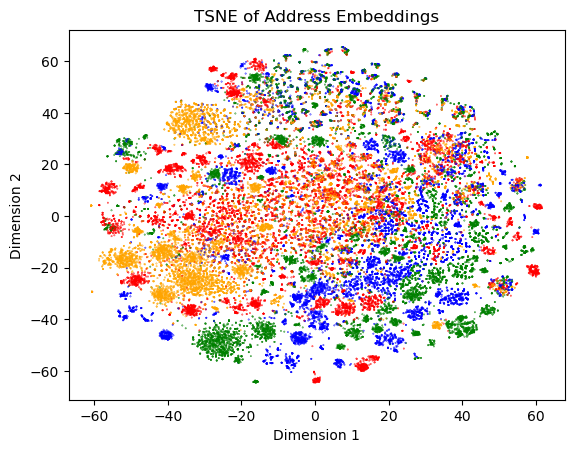

In [14]:
# Plot the TSNE. #
plt.scatter(
    embed_tsne[:, 0], embed_tsne[:, 1], 
    s=0.1, c=np.array(colours)[idx_filtered])

plt.title("TSNE of Address Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
#plt.legend(["01", "02", "03", "04", "05"])

plt.savefig("TSNE_Address_Embeddings.jpg")